## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果

In [1]:
import os
import keras
from keras.layers import BatchNormalization
from sklearn.metrics import precision_score, recall_score, classification_report
import numpy as np

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# Enable GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
        else:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4., ce_weight=0.):
    gamma = float(gamma)
    alpha = float(alpha)
    def ce_fo_loss(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        # 撰寫自定義的 loss function: focal loss (https://blog.csdn.net/u014380165/article/details/77019084)
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        fo_loss = tf.reduce_mean(reduced_fl)
        
        # cross entropy loss
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        
        return tf.add(tf.multiply(fo_loss, (1-ce_weight)), tf.multiply(ce_loss, ce_weight))  
    return ce_fo_loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [10]:
# ce_w = 0.7
# model = build_mlp(input_shape=x_train.shape[1:])
# model.summary()
# optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
# #model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
# model.compile(loss=combined_loss(ce_weight=ce_w), metrics=["accuracy"], optimizer=optimizer)

# """Code Here
# 將 callbacks 放入模型訓練流程中
# """
# model.fit(x_train, y_train, 
#           epochs=EPOCHS, 
#           batch_size=BATCH_SIZE, 
#           validation_data=(x_test, y_test), 
#           shuffle=True
#          )
# # Collect results
# train_loss = model.history.history["loss"]
# valid_loss = model.history.history["val_loss"]
# train_acc = model.history.history["accuracy"]
# valid_acc = model.history.history["val_accuracy"]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_3 (ReLU)               (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 256)               0   

In [11]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_weight=ce_w), metrics=["accuracy"], optimizer=optimizer)
    #model.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (ce_w))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_7 (ReLU)          

Epoch 8/25
49/49 [==============================] - 2s 32ms/step - loss: 2.5002 - accuracy: 0.5795 - val_loss: 3.1753 - val_accuracy: 0.4769
Epoch 9/25
49/49 [==============================] - 2s 33ms/step - loss: 2.3861 - accuracy: 0.5959 - val_loss: 3.2285 - val_accuracy: 0.4750
Epoch 10/25
49/49 [==============================] - 2s 31ms/step - loss: 2.2812 - accuracy: 0.6105 - val_loss: 3.1968 - val_accuracy: 0.4768
Epoch 11/25
49/49 [==============================] - 2s 32ms/step - loss: 2.1771 - accuracy: 0.6262 - val_loss: 3.1669 - val_accuracy: 0.4864
Epoch 12/25
49/49 [==============================] - 2s 32ms/step - loss: 2.0777 - accuracy: 0.6424 - val_loss: 3.1761 - val_accuracy: 0.4811
Epoch 13/25
49/49 [==============================] - 2s 31ms/step - loss: 1.9865 - accuracy: 0.6574 - val_loss: 3.1558 - val_accuracy: 0.4868
Epoch 14/25
49/49 [==============================] - 2s 31ms/step - loss: 1.8924 - accuracy: 0.6680 - val_loss: 3.1553 - val_accuracy: 0.4880
Epoch 15

Epoch 1/25
49/49 [==============================] - 2s 34ms/step - loss: 3.3980 - accuracy: 0.2754 - val_loss: 3.4203 - val_accuracy: 0.2194
Epoch 2/25
49/49 [==============================] - 2s 31ms/step - loss: 2.6163 - accuracy: 0.4059 - val_loss: 3.1773 - val_accuracy: 0.2787
Epoch 3/25
49/49 [==============================] - 2s 31ms/step - loss: 2.4064 - accuracy: 0.4507 - val_loss: 2.8908 - val_accuracy: 0.3477
Epoch 4/25
49/49 [==============================] - 1s 30ms/step - loss: 2.2751 - accuracy: 0.4738 - val_loss: 2.6356 - val_accuracy: 0.4135
Epoch 5/25
49/49 [==============================] - 2s 32ms/step - loss: 2.1709 - accuracy: 0.4978 - val_loss: 2.4754 - val_accuracy: 0.4354
Epoch 6/25
49/49 [==============================] - 1s 31ms/step - loss: 2.0852 - accuracy: 0.5155 - val_loss: 2.4225 - val_accuracy: 0.4412
Epoch 7/25
49/49 [==============================] - 2s 31ms/step - loss: 2.0109 - accuracy: 0.5323 - val_loss: 2.3097 - val_accuracy: 0.4614
Epoch 8/25
49

Epoch 21/25
49/49 [==============================] - 2s 31ms/step - loss: 1.1518 - accuracy: 0.6051 - val_loss: 1.4256 - val_accuracy: 0.4919
Epoch 22/25
49/49 [==============================] - 2s 31ms/step - loss: 1.1355 - accuracy: 0.6105 - val_loss: 1.4334 - val_accuracy: 0.4929
Epoch 23/25
49/49 [==============================] - 2s 31ms/step - loss: 1.1186 - accuracy: 0.6160 - val_loss: 1.4348 - val_accuracy: 0.4860
Epoch 24/25
49/49 [==============================] - 2s 31ms/step - loss: 1.1018 - accuracy: 0.6229 - val_loss: 1.4194 - val_accuracy: 0.4992
Epoch 25/25
49/49 [==============================] - 2s 31ms/step - loss: 1.0855 - accuracy: 0.6298 - val_loss: 1.4226 - val_accuracy: 0.4961


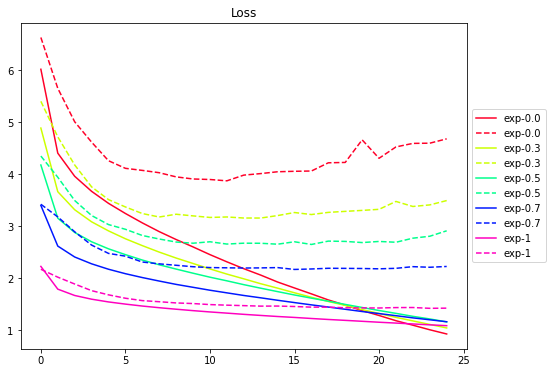

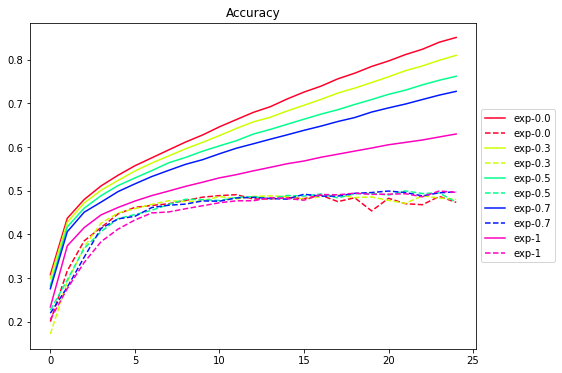

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()